In [1]:
import fastf1 as ff1
import pandas as pd
import sys
import os
sys.path.append(os.path.dirname("/home/ben/Individual_Project/DB"))
from DB.models import Circuit, RacingWeekend, Driver, Session, SessionResult, init_db
from database_operations import DatabaseOperations
from race_data import RaceDataSetup
from overtake_model import OvertakingModel

from race_dataframe import RaceDataframe
from race_sim import RaceSimulator
from evaluation import RaceSimEvaluation
import matplotlib.pyplot as plt
import numpy as np

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) 

In [2]:
db = DatabaseOperations(2024, "Sakhir")
race_dataframe = RaceDataframe(db)
race_setup = RaceDataSetup(db, race_dataframe)
overtake = OvertakingModel(race_dataframe.race_df)


In [3]:
df = race_dataframe.race_df

max_laps_per_driver = df.groupby('driver_number')['lap_num'].max()
max_lap_all_drivers = max_laps_per_driver.min()
actual_df = df[(df["lap_num"]==max_lap_all_drivers) & (df["sector"]==3)]

print(max_lap_all_drivers)
race_setup.max_laps = max_lap_all_drivers
simulation = RaceSimulator(race_setup, overtake)
simulation.simulate()
sim_df = simulation.get_results_as_dataframe()


55


In [4]:
sim_df

,driver_number,driver_name,pit_schedule,tyre_type,lap_num,sector,sector_time,stint_lap,cumulative_time,gap,pit,pace,position,starting_pos,base_sector_times,tyre_diff,stint_laps_diff,drs_available,retired,predicted_overtake
0,11,Sergio Perez,"{13: 3, 37: 1, 1: 1}",1,55,3,23.668539,19,5525.639327,0.000000,False,32.022224,1,2,"{1: 28.738, 2: 38.323, 3: 22.41}",2,19,False,False,False
1,55,Carlos Sainz,"{15: 3, 36: 3, 1: 1}",3,55,3,23.527383,20,5535.697871,10.058543,False,23.549103,2,3,"{1: 28.85, 2: 38.298, 3: 22.337}",-2,-1,False,False,False
2,63,George Russell,"{12: 3, 32: 3, 1: 1}",3,55,3,23.723490,24,5539.957401,4.259530,False,23.730648,3,5,"{1: 28.8, 2: 38.421, 3: 22.264}",0,-4,False,False,False
3,44,Lewis Hamilton,"{13: 3, 34: 3, 1: 1}",3,55,3,23.638224,22,5543.708170,3.750769,False,23.678371,4,7,"{1: 28.803, 2: 38.422, 3: 22.369}",0,2,False,False,False
4,4,Lando Norris,"{14: 3, 34: 3, 1: 1}",3,55,3,23.859594,22,5551.385354,7.677184,False,23.894542,5,6,"{1: 28.836, 2: 38.207, 3: 22.362}",0,0,False,False,False
5,16,Charles Leclerc,"{12: 3, 35: 3, 1: 1}",3,55,3,23.814609,21,5551.514701,0.129348,False,23.817187,6,4,"{1: 28.762, 2: 38.059, 3: 22.263}",0,1,True,False,False
6,81,Oscar Piastri,"{13: 3, 35: 3, 1: 1}",3,55,3,23.901169,21,5558.317917,6.803216,False,23.908106,7,8,"{1: 28.901, 2: 38.343, 3: 22.439}",0,0,False,False,False
7,14,Fernando Alonso,"{16: 3, 42: 3, 1: 1}",3,55,3,23.562612,14,5576.014884,17.696967,False,23.615817,8,9,"{1: 28.83, 2: 38.236, 3: 22.374}",0,7,False,False,False
8,18,Lance Stroll,"{10: 3, 28: 3, 1: 1}",3,55,3,24.136371,28,5583.398169,7.383285,False,24.174333,9,10,"{1: 28.65, 2: 38.609, 3: 22.694}",0,-14,False,False,False
9,3,Daniel Ricciardo,"{14: 3, 36: 1, 1: 1}",1,55,3,24.112576,20,5588.577072,5.178904,False,24.121379,10,13,"{1: 28.884, 2: 38.802, 3: 22.592}",2,8,False,False,False


In [5]:

# Step 1: Sort both DataFrames by cumulative time
actual_df = actual_df.sort_values(by='cumulative_time').reset_index(drop=True)
sim_df = sim_df.sort_values(by='cumulative_time').reset_index(drop=True)

# Step 2: Compute gaps to the driver in 1st place
# For actual_df
first_place_actual_time = actual_df['cumulative_time'].iloc[0]  # Cumulative time of the driver in 1st place
actual_df['gap_to_first_place'] = actual_df['cumulative_time'] - first_place_actual_time

# For sim_df
first_place_simulated_time = sim_df['cumulative_time'].iloc[0]  # Cumulative time of the driver in 1st place
sim_df['gap_to_first_place'] = sim_df['cumulative_time'] - first_place_simulated_time

# Step 3: Merge the two DataFrames on driver_number to align gaps
merged_df = pd.merge(
    actual_df[['driver_number', 'cumulative_time', 'gap_to_first_place']],  # Include 'gap_to_first_place' from actual_df
    sim_df[['driver_number', 'cumulative_time', 'gap_to_first_place']],     # Include 'gap_to_first_place' from sim_df
    on='driver_number',
    how='inner',  # Ensure only matching drivers are included
    suffixes=('_actual', '_simulated')  # Use suffixes to differentiate cumulative times
)


merged_df['error_in_gaps_to_first'] = (merged_df['gap_to_first_place_simulated'] - merged_df['gap_to_first_place_actual'])

merged_df['error_in_cumulative_time'] = (merged_df['cumulative_time_actual'] - merged_df['cumulative_time_simulated'])

merged_df['abs_error_in_gaps_to_first'] = (merged_df['gap_to_first_place_simulated'] - merged_df['gap_to_first_place_actual']).abs()

merged_df['abs_error_in_cumulative_time'] = (merged_df['cumulative_time_actual'] - merged_df['cumulative_time_simulated']).abs()

# # Optional: Summary statistics
# gap_to_first_stats = merged_df['abs_error_in_gaps_to_first'].describe()
# correlation = merged_df['cumulative_time_actual'].corr(merged_df['cumulative_time_simulated'], method='spearman')

# # Display results
# print("\nSummary Statistics for Error in Gaps to First Place:")
# print(gap_to_first_stats)

# print("\nCorrelation between Actual and Simulated Cumulative Times:")
# print(correlation)

In [6]:
# from scipy.stats import zscore

# # Calculate Z-scores for cumulative time errors
# merged_df['z_score_cumulative'] = zscore(merged_df['abs_error_in_cumulative_time'])

# # Filter out rows where Z-score > 3 or < -3
# merged_df = merged_df[(merged_df['z_score_cumulative'].abs() <= 3)]

# # Repeat for gaps to first place errors
# merged_df['z_score_gaps'] = zscore(merged_df['abs_error_in_gaps_to_first'])
# merged_df = merged_df[(merged_df['z_score_gaps'].abs() <= 3)]

In [7]:
merged_df

,driver_number,cumulative_time_actual,gap_to_first_place_actual,cumulative_time_simulated,gap_to_first_place_simulated,error_in_gaps_to_first,error_in_cumulative_time,abs_error_in_gaps_to_first,abs_error_in_cumulative_time
0,1,5282.746,0.000,5591.245611,65.606284,65.606284,-308.499611,65.606284,308.499611
1,11,5302.298,19.552,5525.639327,0.000000,-19.552000,-223.341327,19.552000,223.341327
2,55,5305.226,22.480,5535.697871,10.058543,-12.421457,-230.471871,12.421457,230.471871
3,16,5319.076,36.330,5551.514701,25.875374,-10.454626,-232.438701,10.454626,232.438701
4,63,5325.305,42.559,5539.957401,14.318073,-28.240927,-214.652401,28.240927,214.652401
5,4,5326.027,43.281,5551.385354,25.746026,-17.534974,-225.358354,17.534974,225.358354
6,44,5328.102,45.356,5543.708170,18.068842,-27.287158,-215.606170,27.287158,215.606170
7,81,5333.994,51.248,5558.317917,32.678590,-18.569410,-224.323917,18.569410,224.323917
8,77,5345.496,62.750,5660.863773,135.224446,72.474446,-315.367773,72.474446,315.367773
9,14,5355.090,72.344,5576.014884,50.375557,-21.968443,-220.924884,21.968443,220.924884


In [8]:
# merged_df['error_cumulative'] = merged_df['cumulative_time_actual'] - merged_df['cumulative_time_simulated']
# mean_error_cumulative = merged_df['error_cumulative'].mean()
# print(f"Mean Error for Cumulative Times: {mean_error_cumulative}")

# merged_df['cumulative_time_simulated_adjusted'] = merged_df['cumulative_time_simulated'] + mean_error_cumulative

# merged_df['error_cumulative_adjusted'] = merged_df['cumulative_time_actual'] - merged_df['cumulative_time_simulated_adjusted']

# wilcoxon_cumulative_adjusted = wilcoxon(merged_df['error_cumulative_adjusted'])
# print("\nWilcoxon Signed-Rank Test for Adjusted Cumulative Time Errors:")
# print(f"Statistic: {wilcoxon_cumulative_adjusted.statistic}, p-value: {wilcoxon_cumulative_adjusted.pvalue}")

In [9]:
from scipy.stats import wilcoxon

# Wilcoxon Signed-Rank Test for abs_error_in_cumulative_time
wilcoxon_cumulative = wilcoxon(merged_df['error_in_cumulative_time'])
print("\nWilcoxon Signed-Rank Test for Cumulative Time Errors:")
print(f"Statistic: {wilcoxon_cumulative.statistic}, p-value: {wilcoxon_cumulative.pvalue}")

# Wilcoxon Signed-Rank Test for abs_error_in_gaps_to_first
wilcoxon_gaps = wilcoxon(merged_df['error_in_gaps_to_first'])
print("\nWilcoxon Signed-Rank Test for Gaps to First Place Errors:")
print(f"Statistic: {wilcoxon_gaps.statistic}, p-value: {wilcoxon_gaps.pvalue}")



from scipy.stats import spearmanr

# Spearman Correlation for cumulative times
spearman_corr_cumulative = spearmanr(merged_df['cumulative_time_actual'], merged_df['cumulative_time_simulated'])
print("\nSpearman Correlation for Cumulative Times:")
print(f"Correlation Coefficient: {spearman_corr_cumulative[0]}, p-value: {spearman_corr_cumulative[1]}")

# Spearman Correlation for gaps to first place
spearman_corr_gaps = spearmanr(merged_df['gap_to_first_place_actual'], merged_df['gap_to_first_place_simulated'])
print("\nSpearman Correlation for Gaps to First Place:")
print(f"Correlation Coefficient: {spearman_corr_gaps[0]}, p-value: {spearman_corr_gaps[1]}")



from scipy.stats import ks_2samp

# KS Test for cumulative times
ks_cumulative = ks_2samp(merged_df['cumulative_time_actual'], merged_df['cumulative_time_simulated'])
print("\nKolmogorov-Smirnov Test for Cumulative Times:")
print(f"Statistic: {ks_cumulative.statistic}, p-value: {ks_cumulative.pvalue}")

# KS Test for gaps to first place
ks_gaps = ks_2samp(merged_df['gap_to_first_place_actual'], merged_df['gap_to_first_place_simulated'])
print("\nKolmogorov-Smirnov Test for Gaps to First Place:")
print(f"Statistic: {ks_gaps.statistic}, p-value: {ks_gaps.pvalue}")


# Calculate Mean Absolute Error for cumulative times
mae_cumulative = (merged_df['abs_error_in_cumulative_time']).mean()
print(f"\nMean Absolute Error for Cumulative Times: {mae_cumulative}")

# Calculate Mean Absolute Error for gaps to first place
mae_gaps = (merged_df['abs_error_in_gaps_to_first']).mean()
print(f"Mean Absolute Error for Gaps to First Place: {mae_gaps}")

import numpy as np

# Calculate Root Mean Squared Error for cumulative times
rmse_cumulative = np.sqrt(((merged_df['cumulative_time_actual'] - merged_df['cumulative_time_simulated'])**2).mean())
print(f"\nRoot Mean Squared Error for Cumulative Times: {rmse_cumulative}")

# Calculate Root Mean Squared Error for gaps to first place
rmse_gaps = np.sqrt(((merged_df['gap_to_first_place_actual'] - merged_df['gap_to_first_place_simulated'])**2).mean())
print(f"Root Mean Squared Error for Gaps to First Place: {rmse_gaps}")


Wilcoxon Signed-Rank Test for Cumulative Time Errors:
Statistic: 0.0, p-value: 1.9073486328125e-06

Wilcoxon Signed-Rank Test for Gaps to First Place Errors:
Statistic: 37.0, p-value: 0.009435653686523438

Spearman Correlation for Cumulative Times:
Correlation Coefficient: 0.7924812030075187, p-value: 3.103086794223732e-05

Spearman Correlation for Gaps to First Place:
Correlation Coefficient: 0.7924812030075187, p-value: 3.103086794223732e-05

Kolmogorov-Smirnov Test for Cumulative Times:
Statistic: 1.0, p-value: 1.4508889103849681e-11

Kolmogorov-Smirnov Test for Gaps to First Place:
Statistic: 0.4, p-value: 0.08105771161340149

Mean Absolute Error for Cumulative Times: 224.83899712523674
Mean Absolute Error for Gaps to First Place: 31.862403044909797

Root Mean Squared Error for Cumulative Times: 227.71473059655037
Root Mean Squared Error for Gaps to First Place: 40.340832143725756


Wilcoxon Signed-Rank Test for Cumulative Time Errors:
Statistic: 0.0, p-value: 1.9073486328125e-06

Wilcoxon Signed-Rank Test for Gaps to First Place Errors:
Statistic: 58.0, p-value: 0.13649771056887278

Spearman Correlation for Cumulative Times:
Correlation Coefficient: 0.8736842105263156, p-value: 4.87296288071922e-07

Spearman Correlation for Gaps to First Place:
Correlation Coefficient: 0.8736842105263156, p-value: 4.87296288071922e-07

Kolmogorov-Smirnov Test for Cumulative Times:
Statistic: 1.0, p-value: 1.4508889103849681e-11

Kolmogorov-Smirnov Test for Gaps to First Place:
Statistic: 0.2, p-value: 0.8319696107963263

Mean Absolute Error for Cumulative Times: 220.88599681089983
Mean Absolute Error for Gaps to First Place: 14.89364482660385

Root Mean Squared Error for Cumulative Times: 222.74540394683848
Root Mean Squared Error for Gaps to First Place: 28.827937278628625


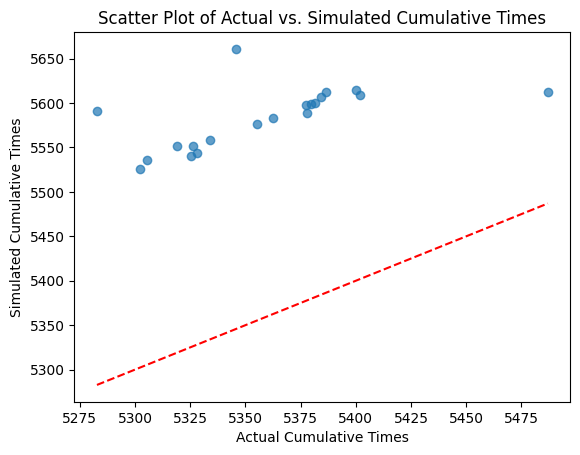

In [10]:
import matplotlib.pyplot as plt

# Scatter plot for cumulative times
plt.scatter(merged_df['cumulative_time_actual'], merged_df['cumulative_time_simulated'], alpha=0.7)
plt.xlabel('Actual Cumulative Times')
plt.ylabel('Simulated Cumulative Times')
plt.title('Scatter Plot of Actual vs. Simulated Cumulative Times')
plt.plot([min(merged_df['cumulative_time_actual']), max(merged_df['cumulative_time_actual'])],
         [min(merged_df['cumulative_time_actual']), max(merged_df['cumulative_time_actual'])], color='red', linestyle='--')
plt.show()

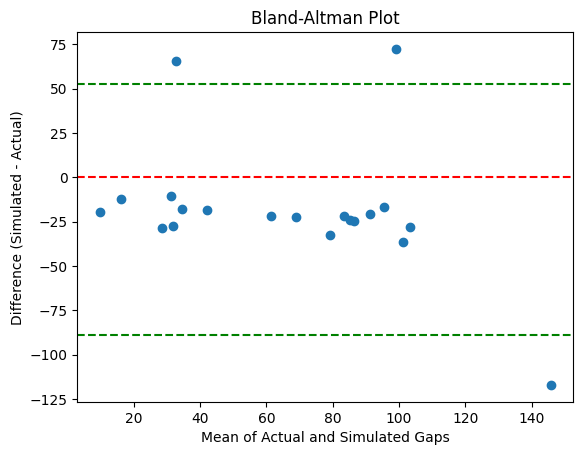

In [11]:


mean_values = (merged_df['gap_to_first_place_actual'] + merged_df['gap_to_first_place_simulated']) / 2
differences = merged_df['gap_to_first_place_simulated'] - merged_df['gap_to_first_place_actual']

# Plot
plt.scatter(mean_values, differences)
plt.axhline(y=0, color='r', linestyle='--')  # Add a reference line at zero
plt.axhline(y=np.mean(differences) + 1.96 * np.std(differences), color='g', linestyle='--')  # Upper limit
plt.axhline(y=np.mean(differences) - 1.96 * np.std(differences), color='g', linestyle='--')  # Lower limit
plt.xlabel('Mean of Actual and Simulated Gaps')
plt.ylabel('Difference (Simulated - Actual)')
plt.title('Bland-Altman Plot')
plt.show()


In [12]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(merged_df['gap_to_first_place_actual'], merged_df['gap_to_first_place_simulated'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")

from scipy.stats import wilcoxon

w_stat, p_value = wilcoxon(merged_df['abs_error_in_cumulative_time'])
print(f"W-statistic: {w_stat}, P-value: {p_value}")

T-statistic: 2.1814677150124155, P-value: 0.041915954248486875
W-statistic: 0.0, P-value: 1.9073486328125e-06


In [13]:
spearman_corr = merged_df['cumulative_time_actual'].corr(merged_df['cumulative_time_simulated'], method='spearman')

print(spearman_corr)

0.7924812030075187
